In [1]:
!pip install torch torchvision torchxrayvision opencv-python requests tqdm pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [19]:
!pip install fpdf2 pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.7/245.7 kB 7.2 MB/s eta 0:00:00


In [29]:
import torch
import torchvision.transforms as transforms
import torchxrayvision as xrv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
from io import BytesIO
import pandas as pd
import re
from tqdm import tqdm

In [3]:
# Load pretrained models
model = xrv.models.DenseNet(weights="densenet121-res224-chex")
chexpert_model = xrv.models.DenseNet(weights="densenet121-res224-chex")  # For validation
model.eval()
chexpert_model.eval()

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    xrv.datasets.XRayCenterCrop(),
    transforms.Normalize([0.5], [0.5])
])

# Disease labels
disease_labels = model.pathologies

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [4]:
def apply_clahe(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(2.0, (8, 8))
    return clahe.apply(gray)

def apply_hist_eq(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.equalizeHist(gray)

def apply_bilateral(img):
    return cv2.bilateralFilter(img, 9, 75, 75)

def apply_unsharp_mask(img):
    gaussian = cv2.GaussianBlur(img, (9, 9), 10.0)
    return cv2.addWeighted(img, 1.5, gaussian, -0.5, 0)

def convert_to_direct_url(link):
    match = re.search(r'id=([a-zA-Z0-9_-]+)', link)
    if match:
        return f"https://drive.google.com/uc?export=download&id={match.group(1)}"
    return None

def detect_noise(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return np.sum(diff) / (img.shape[0] * img.shape[1])

def apply_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, threshold1=100, threshold2=200)

def apply_median_filter(img):
    return cv2.medianBlur(img, 5)

def apply_gaussian_filter(img):
    return cv2.GaussianBlur(img, (5, 5), 1.5)

In [5]:
# Medical reference for symptoms and treatments
diagnosis_info = {
    "Atelectasis": {
        "Symptoms": "Shortness of breath, chest pain, cough.",
        "Treatment": "Physiotherapy, breathing exercises, surgery if needed."
    },
    "Cardiomegaly": {
        "Symptoms": "Fatigue, shortness of breath, swelling.",
        "Treatment": "Medication, treating underlying heart condition."
    },
    "Consolidation": {
        "Symptoms": "Fever, cough with sputum, chest discomfort.",
        "Treatment": "Antibiotics, rest, fluids."
    },
    "Effusion": {
        "Symptoms": "Chest pain, shortness of breath.",
        "Treatment": "Drainage, medication to treat cause."
    },
    "Infiltration": {
        "Symptoms": "Fever, chills, cough.",
        "Treatment": "Depends on cause — antibiotics or antifungals."
    },
    "Lung Opacity": {
        "Symptoms": "Often asymptomatic or with cough and breathlessness.",
        "Treatment": "Treat the underlying condition (e.g., pneumonia)."
    },
    "Pneumothorax": {
        "Symptoms": "Sharp chest pain, sudden breathlessness.",
        "Treatment": "Observation, chest tube, surgery."
    },
    "No Finding": {
        "Symptoms": "None.",
        "Treatment": "No action needed."
    }
}

In [11]:
def validate_with_chexpert(image_url, your_top3_str):
    """Enhanced validation with better error handling"""
    try:
        # Download image with timeout and retry
        try:
            response = requests.get(image_url, timeout=10)
            response.raise_for_status()
            img_data = BytesIO(response.content)
            img = Image.open(img_data)
            img = img.convert("RGB")  # Ensure RGB format
        except Exception as e:
            print(f"⚠️ Image download failed for {image_url[:50]}...: {str(e)[:100]}")
            return None

        try:
            # Convert to grayscale tensor
            img_tensor = transform(transforms.functional.to_grayscale(img, 1)).unsqueeze(0)

            # Get CheXpert predictions
            with torch.no_grad():
                chex_pred = torch.sigmoid(chexpert_model(img_tensor)[0])

            # Process predictions
            your_dx = [x.split(" (")[0] for x in your_top3_str.split("; ")[:3]]
            chex_top3 = sorted(
                [(chexpert_model.pathologies[i], float(chex_pred[i]))
                 for i in range(len(chex_pred)) if chex_pred[i] > 0.5],
                key=lambda x: x[1], reverse=True
            )[:3]

            matches = set(your_dx) & {x[0] for x in chex_top3}
            return {
                'chexpert_findings': "; ".join(f"{k} ({v:.2f})" for k,v in chex_top3),
                'agreement_score': len(matches)/3,
                'matching_conditions': ", ".join(matches) if matches else "None"
            }

        except Exception as e:
            print(f"⚠️ Validation processing failed: {str(e)[:100]}")
            return None

    except Exception as e:
        print(f"⚠️ Unexpected validation error: {str(e)[:100]}")
        return None

In [12]:
# Load dataset
df = pd.read_csv('/content/dataset.csv')
image_urls = df['Images Links'].dropna().tolist()

# Initialize new columns
df['top3_diagnoses'] = None
df['chexpert_findings'] = None
df['agreement_score'] = None
df['matching_conditions'] = None


Processing Image 1

Noise Level: 0.91


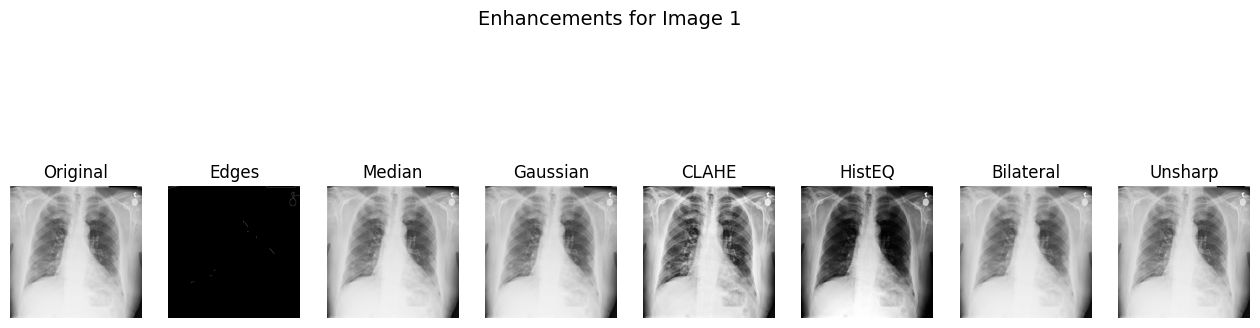


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 2

Noise Level: 1.40


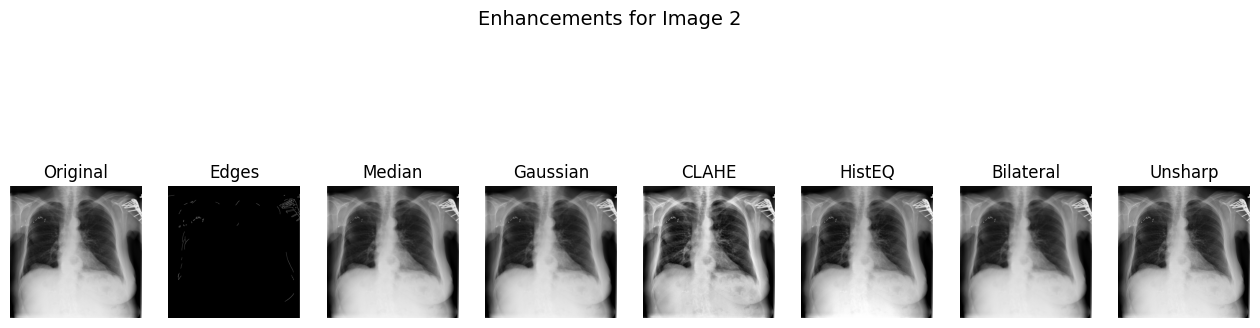


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 3

Noise Level: 1.58


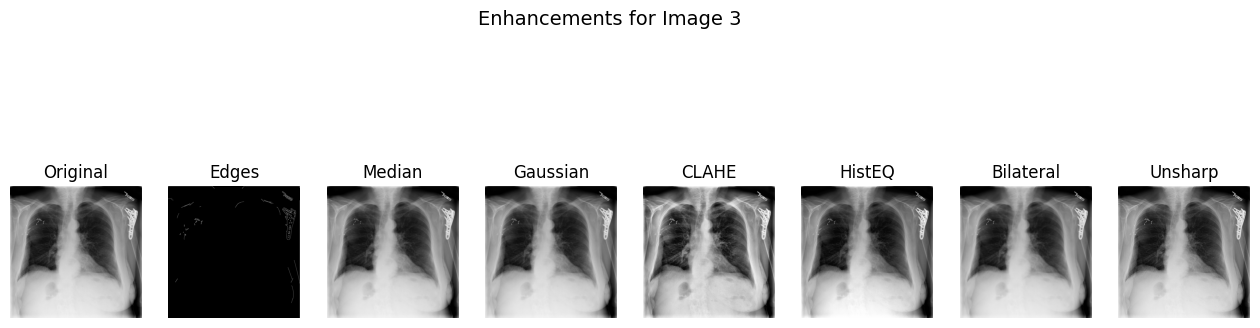


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 4

Noise Level: 1.06


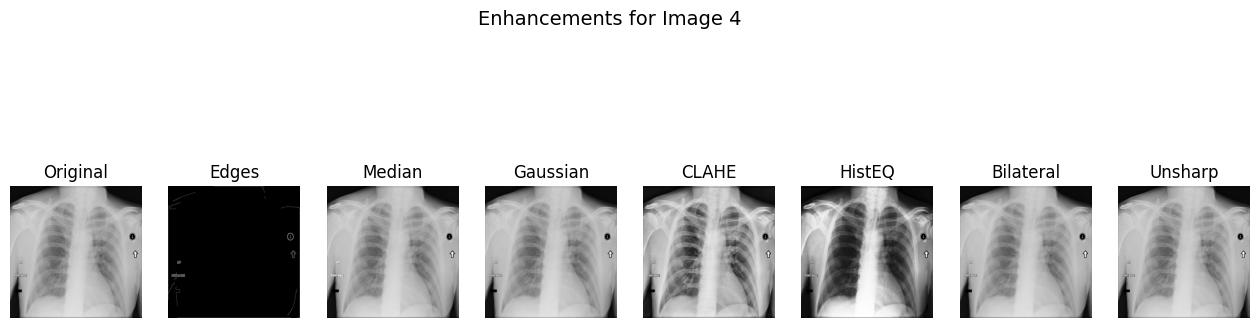


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 5

Noise Level: 1.06


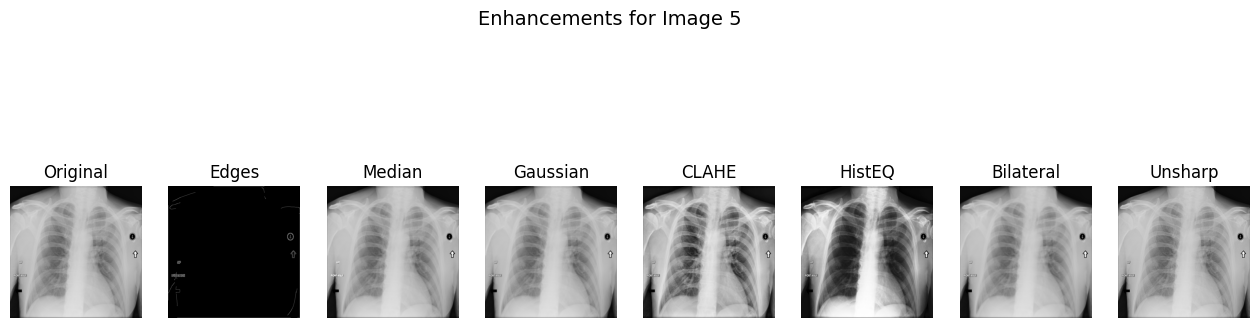


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 6

Noise Level: 1.02


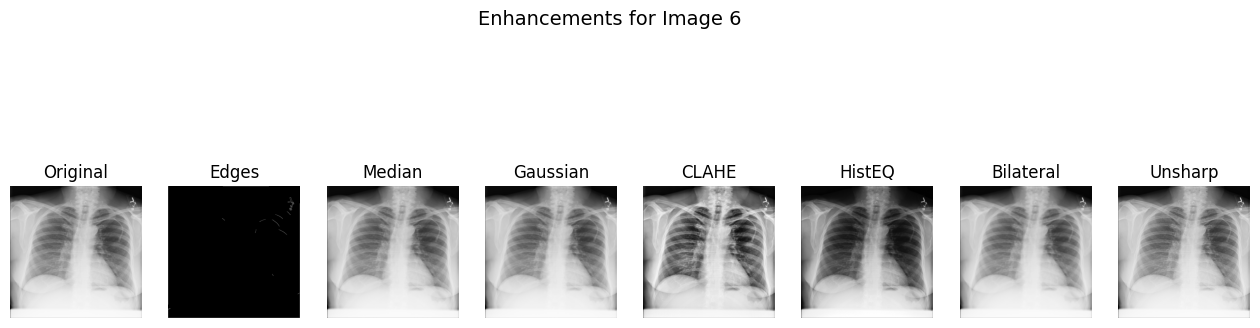


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 7

Noise Level: 0.73


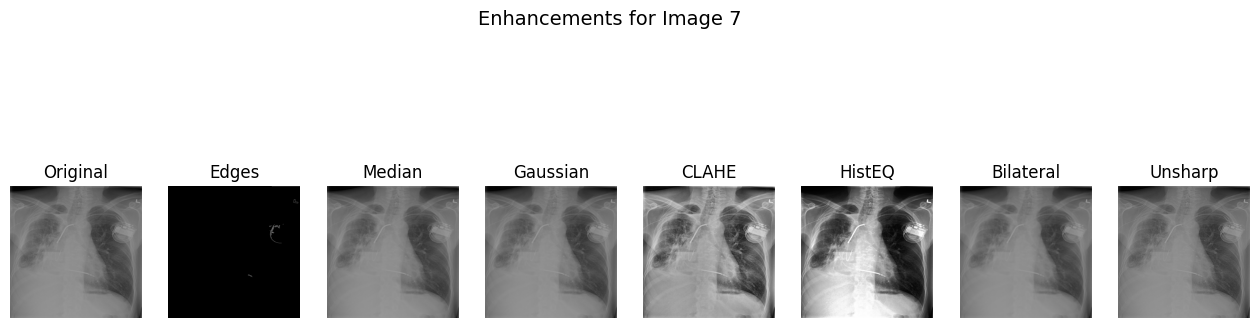


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 8

Noise Level: 0.95


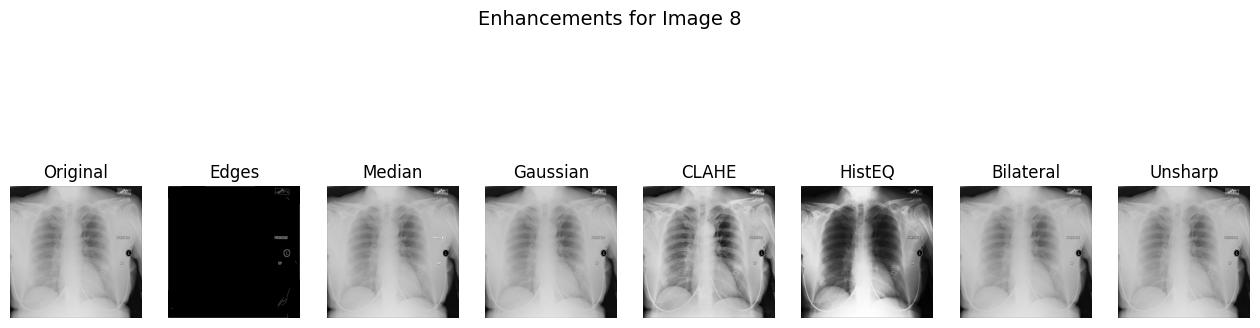


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 9

Noise Level: 1.47


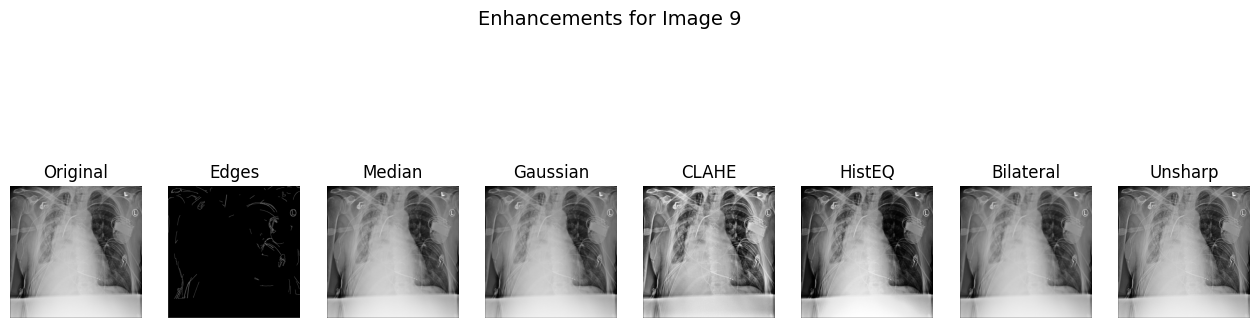


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Processing Image 10

Noise Level: 0.92


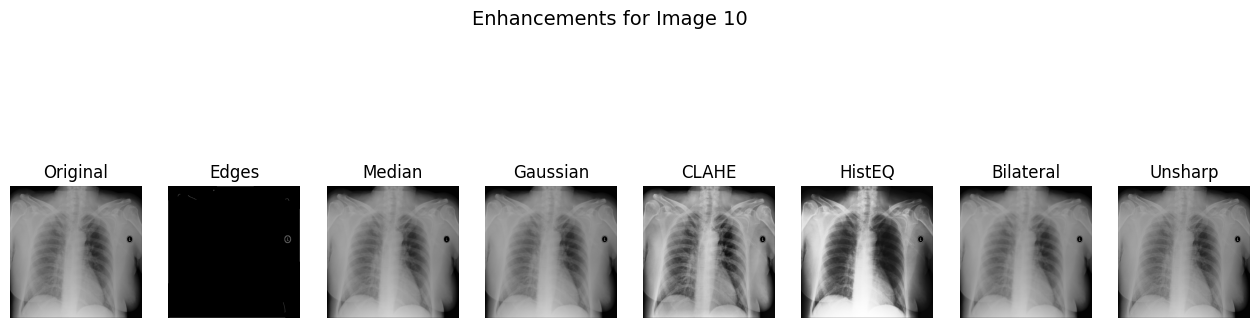


🔍 Top Diagnoses:
  Lung Opacity (0.89):
    Symptoms: Often asymptomatic or with cough and breathlessness.
    Treatment: Treat the underlying condition (e.g., pneumonia).
  Effusion (0.87):
    Symptoms: Chest pain, shortness of breath.
    Treatment: Drainage, medication to treat cause.
  Atelectasis (0.82):
    Symptoms: Shortness of breath, chest pain, cough.
    Treatment: Physiotherapy, breathing exercises, surgery if needed.

✅ Validation Results:
  CheXpert Findings: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
  Agreement Score: 100%
  Matching Conditions: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------


In [34]:
import time  # Add this with your other imports

MAX_RETRIES = 2
TIMEOUT = 10  # seconds

def safe_image_load(url):
    """Load image with retries and timeout"""
    for attempt in range(MAX_RETRIES):
        try:
            response = requests.get(url, timeout=TIMEOUT)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
            return img.convert("RGB")
        except Exception as e:
            if attempt == MAX_RETRIES-1:
                raise
            print(f"⚠️ Retry {attempt+1} for image load...")
            time.sleep(1)  # Brief pause before retry
    return None

for idx, url in enumerate(image_urls[:10]):  # Process first 5 images
    print(f"\n{'='*40}\nProcessing Image {idx+1}\n{'='*40}")

    try:
        # Step 1: Safe image loading
        direct_url = convert_to_direct_url(url)
        if not direct_url:
            print(f"❗ Invalid URL format: {url[:50]}...")
            df.at[idx, 'error'] = "Invalid URL format"
            continue

        img = safe_image_load(direct_url)
        if img is None:
            print("❗ Failed to load image after retries")
            df.at[idx, 'error'] = "Failed to load image after retries"
            continue

        # Step 2: Image processing
        img_np = np.array(img)
        img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Noise detection
        noise_level = detect_noise(img_cv)
        print(f"\nNoise Level: {noise_level:.2f}")

        # Apply all filters
        processed_images = {
            'Original': img_cv,
            'Edges': apply_edge_detection(img_cv),
            'Median': apply_median_filter(img_cv),
            'Gaussian': apply_gaussian_filter(img_cv),
            'CLAHE': apply_clahe(img_cv),
            'HistEQ': apply_hist_eq(img_cv),
            'Bilateral': apply_bilateral(img_cv),
            'Unsharp': apply_unsharp_mask(img_cv)
        }

        # Display enhancements
        plt.figure(figsize=(16, 5))
        for i, (title, im) in enumerate(processed_images.items()):
            plt.subplot(1, 8, i+1)
            if len(im.shape) == 2:
                plt.imshow(im, cmap='gray')
            else:
                plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            plt.title(title)
            plt.axis('off')
        plt.suptitle(f"Enhancements for Image {idx+1}", fontsize=14)
        plt.show()

        # Step 3: Prediction
        img_pil = transforms.functional.to_grayscale(img, num_output_channels=1)
        img_tensor = transform(img_pil).unsqueeze(0)

        with torch.no_grad():
            output = model(img_tensor)[0]

        # Get and store top 3 predictions
        preds = sorted([(disease_labels[i], float(output[i]))
                       for i in range(len(output))],
                      key=lambda x: x[1], reverse=True)[:3]
        top3_str = "; ".join([f"{disease} ({prob:.2f})" for disease, prob in preds])
        df.at[idx, 'top3_diagnoses'] = top3_str

        # Display predictions
        print(f"\n🔍 Top Diagnoses:")
        for disease, prob in preds:
            info = diagnosis_info.get(disease, {})
            print(f"  {disease} ({prob:.2f}):")
            print(f"    Symptoms: {info.get('Symptoms', 'Not available')}")
            print(f"    Treatment: {info.get('Treatment', 'Not available')}")

        # Step 4: Validation
        val_result = validate_with_chexpert(convert_to_direct_url(url), top3_str)
        if val_result:
            df.at[idx, 'chexpert_findings'] = val_result['chexpert_findings']
            df.at[idx, 'agreement_score'] = val_result['agreement_score']
            df.at[idx, 'matching_conditions'] = val_result['matching_conditions']
            print(f"\n✅ Validation Results:")
            print(f"  CheXpert Findings: {val_result['chexpert_findings']}")
            print(f"  Agreement Score: {val_result['agreement_score']:.0%}")
            print(f"  Matching Conditions: {val_result['matching_conditions']}")
        else:
            print("\n⚠️ Validation failed for this image")
            df.at[idx, 'error'] = "Validation failed"

    except requests.exceptions.RequestException as e:
        error_msg = f"Network error: {str(e)[:200]}"
        print(f"❗ {error_msg}")
        df.at[idx, 'error'] = error_msg
    except IOError as e:
        error_msg = f"Image processing error: {str(e)[:200]}"
        print(f"❗ {error_msg}")
        df.at[idx, 'error'] = error_msg
    except Exception as e:
        error_msg = f"Processing error: {str(e)[:200]}"
        print(f"❗ {error_msg}")
        df.at[idx, 'error'] = error_msg

    print("-" * 60)

In [35]:
# Save results
df.to_csv('enhanced_xrays_with_validation.csv', index=False)
print("\n✅ Processing complete! Results saved to CSV.")

# Validation summary
validated = df.dropna(subset=['agreement_score'])
if len(validated) > 0:
    print("\n📊 Validation Summary:")
    print(f"Average agreement: {validated['agreement_score'].mean():.2%}")
    print(f"Perfect matches: {(validated['agreement_score'] == 1).sum()}/{len(validated)}")

    print("\n🔬 Sample Comparisons:")
    for _, row in validated.sample(min(3, len(validated))).iterrows():
        print(f"\nImage {row.name+1}:")
        print(f"Your DX: {row['top3_diagnoses']}")
        print(f"CheXpert: {row['chexpert_findings']}")
        print(f"Agreement: {row['agreement_score']:.0%} | Matches: {row['matching_conditions']}")
        print("-"*60)


✅ Processing complete! Results saved to CSV.

📊 Validation Summary:
Average agreement: 100.00%
Perfect matches: 10/10

🔬 Sample Comparisons:

Image 7:
Your DX: Lung Opacity (0.89); Effusion (0.87); Atelectasis (0.82)
CheXpert: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
Agreement: 100% | Matches: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Image 10:
Your DX: Lung Opacity (0.89); Effusion (0.87); Atelectasis (0.82)
CheXpert: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
Agreement: 100% | Matches: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------

Image 5:
Your DX: Lung Opacity (0.89); Effusion (0.87); Atelectasis (0.82)
CheXpert: Lung Opacity (0.71); Effusion (0.70); Atelectasis (0.70)
Agreement: 100% | Matches: Lung Opacity, Atelectasis, Effusion
------------------------------------------------------------
